#Character Level Seq2Seq

##Import all necessary libraries

In [59]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import drive
from nltk.translate.bleu_score import corpus_bleu
import re
import nltk
# drive.mount('/content/drive')

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Function to convert all sentences into lower case

In [61]:
def conv_lower_case(input_texts):
  lower_case=[]
  for sentence in input_texts:
    lower_case.append(sentence.lower())
  return lower_case

##Function to remove quotes

In [62]:
def remove_quotes(input_texts):
  remove_quotes=[]
  for sentence in input_texts:
    remove_quotes.append(re.sub("'","",sentence))
  return remove_quotes

##Merge all datasets 

In [91]:
# Vectorize the data.
input_texts = []
target_texts = []
data_path = "/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/urd.txt"
num_samples=10000
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
#     # We use "tab" as the "start sequence" character
    input_texts.append(input_text)
    target_texts.append(target_text)
print("##################################################################")
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/dev.ur', "r", encoding="utf-8") as f:
    lines_urdu = f.read().split("\n")
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/dev.en', "r", encoding="utf-8") as f:
    lines_eng = f.read().split("\n")

for each in lines_urdu:
   target_texts.append(each)

for each in lines_eng:
  input_texts.append(each)
#########################Bible Data############################################
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/train.ur', "r", encoding="utf-8") as f:
    lines_urdu = f.read().split("\n")
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/train.en', "r", encoding="utf-8") as f:
    lines_eng = f.read().split("\n")
    # print(lines_eng)
for each in lines_urdu:
   target_texts.append(each)

for each in lines_eng:
  input_texts.append(each)

################Quran Data##########################
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Quran/train.ur', "r", encoding="utf-8") as f:
    lines_urdu = f.read().split("\n")
    # print(len(lines))
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Quran/train.en', "r", encoding="utf-8") as f:
    lines_eng = f.read().split("\n")
for each in lines_urdu:
   target_texts.append(each)

for each in lines_eng:
  input_texts.append(each)

###########################Quran Data#########################################
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Quran/dev.ur', "r", encoding="utf-8") as f:
    lines_urdu = f.read().split("\n")

with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Quran/dev.en', "r", encoding="utf-8") as f:
    lines_eng = f.read().split("\n")

for each in lines_urdu:
   target_texts.append(each)

for each in lines_eng:
  input_texts.append(each)

#####################################################################

##################################################################


In [92]:
input_texts=conv_lower_case(input_texts)
input_texts=remove_quotes(input_texts)
target_texts=remove_quotes(target_texts)

##Maintain character sets for both source and target data 

In [93]:
def inp_out_characters(source_sentences,target_sentences):
  input_characters = set()
  target_characters = set()
  target_texts_updated=[]
  for each in input_texts:
    for char in each:
        if char not in input_characters:
            input_characters.add(char)
  for each in target_texts:
    val= "\n" + each + "\t"
    target_texts_updated.append(val)
    for char in val:
        if char not in target_characters:
            target_characters.add(char)
  input_characters = sorted(list(input_characters))
  target_characters = sorted(list(target_characters))
  return input_characters,target_characters,target_texts_updated

In [94]:
def data_stats(input_characters,target_characters,source_sentences,target_sentences): 
  num_encoder_tokens = len(input_characters) 
  num_decoder_tokens = len(target_characters)
  max_encoder_seq_length = max([len(txt) for txt in source_sentences])
  max_decoder_seq_length = max([len(txt) for txt in target_sentences])
  return num_encoder_tokens,num_decoder_tokens,max_encoder_seq_length,max_decoder_seq_length

In [95]:
input_characters,target_characters,target_texts=inp_out_characters(input_texts,target_texts)
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [96]:
num_encoder_tokens,num_decoder_tokens,max_encoder_seq_length,max_decoder_seq_length=data_stats(input_characters,target_characters,input_texts,target_texts)
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 15061
Number of unique input tokens: 53
Number of unique output tokens: 98
Max sequence length for inputs: 1203
Max sequence length for outputs: 986


##Data Split into Training & Validation

In [97]:
X_train, X_test, y_train, y_test = train_test_split(input_texts, target_texts, test_size=0.1, random_state=42)

##To avoid memory crash issues a generaor function is created for encoding for source and target characters

In [70]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_encoder_seq_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_encoder_seq_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_encoder_seq_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text):
                    #print("Input Words",word)
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text):
                    #print("Target words",word)
                    if t<len(target_text)-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

##Encoder Architecture

In [71]:
# Encoder
latent_dim = 256
encoder_inputs = keras.Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

##Encoder states supplied as decoder initial state

In [72]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    13568       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    25088       ['input_2[0][0]']                
                                                                                              

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 30

##Generator function for model fitting to fetch one record at a time to avoid memory crash issues

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs, 
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

<ipython-input-18-60427f4dd8dc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


Epoch 1/30
105/105 [==============================] - 350s 3s/step - loss: 0.2745 - accuracy: 0.2919 - val_loss: 0.2345 - val_accuracy: 0.3566
Epoch 2/30
105/105 [==============================] - 324s 3s/step - loss: 0.2246 - accuracy: 0.3829 - val_loss: 0.2109 - val_accuracy: 0.4128
Epoch 3/30
105/105 [==============================] - 327s 3s/step - loss: 0.2049 - accuracy: 0.4318 - val_loss: 0.1942 - val_accuracy: 0.4560
Epoch 4/30
105/105 [==============================] - 327s 3s/step - loss: 0.1896 - accuracy: 0.4701 - val_loss: 0.1820 - val_accuracy: 0.4838
Epoch 5/30
105/105 [==============================] - 330s 3s/step - loss: 0.1778 - accuracy: 0.5000 - val_loss: 0.1717 - val_accuracy: 0.5144
Epoch 6/30
105/105 [==============================] - 326s 3s/step - loss: 0.1684 - accuracy: 0.5230 - val_loss: 0.1632 - val_accuracy: 0.5329
Epoch 7/30
105/105 [==============================] - 328s 3s/step - loss: 0.1614 - accuracy: 0.5411 - val_loss: 0.1573 - val_accuracy: 0.5506

In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/NLP_Project/char_level_model.h5')

In [73]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/NLP_Project/char_level_model.h5')

##Decoder architecture

In [74]:
encoder_model = keras.Model(encoder_inputs, encoder_states)

#decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb2=dec_emb_layer(decoder_inputs)
#decoder_lstm = model.layers[3]

decoder_outputs2, state_h_dec, state_c_dec = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h_dec, state_c_dec]
#decoder_dense = model.layers[4]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2
)


In [75]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

##Function to decode/translate the input seq

In [76]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq,verbose=0)
    #print("state value predictions: ",states_value)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0]= target_token_index['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value,verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > 100:
            stop_condition = True
            #print("Inside break cond")

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] =sampled_token_index

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [77]:
train_gen=generate_batch(X_train,y_train,batch_size=1)
k=-1

In [78]:
X_train[0]

'abraham saith unto him , they have moses and the prophets ; let them hear them .'

In [79]:
y_train[0]

'\nابرہام نے اس سے کہا ان کے پاس موسٰی اور انبیا تو ہیں ۔ ان کی سنیں ۔\t'

In [80]:
k+=1
print(k)
(input_seq,actual_output),_=next(train_gen)
print(input_seq)
decoded_sentence=decode_sequence(input_seq)
print(input_seq[0].shape)
print('Input Source sentence:', X_train[k:k+1])
print('Actual Target Translation:', y_train[k:k+1])
print('Predicted Target Translation:', decoded_sentence)

0
[[25. 26. 42. ...  0.  0.  0.]]
(1203,)
Input Source sentence: ['abraham saith unto him , they have moses and the prophets ; let them hear them .']
Actual Target Translation: ['\nابرہام نے اس سے کہا ان کے پاس موسٰی اور انبیا تو ہیں ۔ ان کی سنیں ۔\t']
Predicted Target Translation: جھے کہ اس کے ساتھ اس کے ساتھ ایسا ہؤا کہ اس کے ساتھ اس کی بات کی بات کی بات کرتے ہو ۔	جار ۔	جھ نہ کر


##Testing

In [ ]:
def anything_goes_translation(src_sentence,max_encoder_seq_length):
  encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
  for i,input_text in enumerate(src_sentence):
    for t, word in enumerate(input_text):
      encoder_input_data[i, t] = input_token_index[word] # encoder input seg
  decoded_sentence=decode_sequence(encoder_input_data)
  return decoded_sentence

In [100]:
def test_data():
  test_source = []
  test_target = []
  with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/test.ur', "r", encoding="utf-8") as f:
      lines_urdu = f.read().split("\n")
  with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/test.en', "r", encoding="utf-8") as f:
      lines_eng = f.read().split("\n")
  for each in lines_eng:
    test_source.append(each)
  for each in lines_urdu:
    test_target.append(each)
  return test_source,test_target
test_source,test_target=test_data()  

In [101]:
test_source=conv_lower_case(test_source)
test_source=remove_quotes(test_source)
test_target=remove_quotes(test_target)

In [102]:
def inp_out_characters(source_sentences,target_sentences):
  input_characters = set()
  target_characters = set()
  target_texts_updated=[]
  for each in source_sentences:
    for char in each:
        if char not in input_characters:
            input_characters.add(char)
  for each in target_sentences:
    val= "\n" + each + "\t"
    target_texts_updated.append(val)
    for char in val:
        if char not in target_characters:
            target_characters.add(char)
  input_characters = sorted(list(input_characters))
  target_characters = sorted(list(target_characters))
  return input_characters,target_characters,target_texts_updated

In [103]:
def data_stats(input_characters,target_characters,source_sentences,target_sentences): 
  num_encoder_tokens = len(input_characters) 
  num_decoder_tokens = len(target_characters)
  max_encoder_seq_length = max([len(txt) for txt in source_sentences])
  max_decoder_seq_length = max([len(txt) for txt in target_sentences])
  return num_encoder_tokens,num_decoder_tokens,max_encoder_seq_length,max_decoder_seq_length

In [104]:
input_characters,target_characters,test_target=inp_out_characters(test_source,test_target)
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [105]:
num_encoder_tokens,num_decoder_tokens,max_encoder_seq_length,max_decoder_seq_length=data_stats(input_characters,target_characters,test_source,test_target)
print("Number of samples:", len(test_source))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 258
Number of unique input tokens: 33
Number of unique output tokens: 50
Max sequence length for inputs: 371
Max sequence length for outputs: 335


##BLEU Score

In [ ]:
result = [] 
total = 0
for i in range(len(test_source)):
  result.append(anything_goes_translation([test_source[i]],max_encoder_seq_length))
  total += nltk.translate.bleu_score.sentence_bleu([test_target[i]], result[-1], weights=[1])
print(total/len(test_source))


0.5043227598614135


In [ ]:
bleu_score=total/len(test_source)
print("Bleu Score: ",bleu_score)

Bleu Score:  0.5043227598614135


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bleu_Score_Char_Level', 'wb') as file:
  pickle.dump(bleu_score, file)

#Neural Machine Translation With Attention

**Source:** https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [1]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 138 kB/s 


In [2]:
pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.6 MB/s 
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 439 kB 64.0 MB/s 
     |████████████████████████████████| 1.7 MB 48.5 MB/s 
     |████████████████████████████████| 6.0 MB 24.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [5]:
import os 
import sys 
import random
import time
import re
import numpy as np 
import pandas as pd
from typing import Any, Tuple 
import nltk
nltk.download('punkt')

import einops 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn import preprocessing 

random.seed(16)
import tensorflow as tf 
import tensorflow_text  as tf_text 
#from Bio import pairwise2
from functools import partial
from collections import deque
import pathlib
use_builtins = True
import pickle as pkl 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Load and merge all the datasets

In [119]:
# Vectorize the data.
input_texts = []
target_texts = []
data_path = "/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/urd.txt"
num_samples=10000
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
#     # We use "tab" as the "start sequence" character
    input_texts.append(input_text)
    target_texts.append(target_text)
print("##################################################################")
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/dev.ur', "r", encoding="utf-8") as f:
    lines_urdu = f.read().split("\n")
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/dev.en', "r", encoding="utf-8") as f:
    lines_eng = f.read().split("\n")

for each in lines_urdu:
   target_texts.append(each)

for each in lines_eng:
  input_texts.append(each)
#########################Bible Data############################################
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/train.ur', "r", encoding="utf-8") as f:
    lines_urdu = f.read().split("\n")
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/train.en', "r", encoding="utf-8") as f:
    lines_eng = f.read().split("\n")
    # print(lines_eng)
for each in lines_urdu:
   target_texts.append(each)

for each in lines_eng:
  input_texts.append(each)

################Quran Data##########################
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Quran/train.ur', "r", encoding="utf-8") as f:
    lines_urdu = f.read().split("\n")
    # print(len(lines))
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Quran/train.en', "r", encoding="utf-8") as f:
    lines_eng = f.read().split("\n")
for each in lines_urdu:
   target_texts.append(each)

for each in lines_eng:
  input_texts.append(each)

###########################Quran Data#########################################
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Quran/dev.ur', "r", encoding="utf-8") as f:
    lines_urdu = f.read().split("\n")

with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Quran/dev.en', "r", encoding="utf-8") as f:
    lines_eng = f.read().split("\n")

for each in lines_urdu:
   target_texts.append(each)

for each in lines_eng:
  input_texts.append(each)

#####################################################################

##################################################################


In [120]:
context_raw=input_texts
target_raw=target_texts
print(len(context_raw))
print(len(target_raw))

15061
15061


In [121]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [122]:
print(context_raw[-2])
print(target_raw[-2])
print(len(context_raw))
print(len(target_raw))

Or feeding on a day of scarcity ( the poor and the needy during famine and scarcity i . e . striving to put an end to their sufferings and economic deadlock ) .
یا بھوک والے دن یعنی قحط و افلاس کے دور میں غریبوں اور محروم المعیشت لوگوں کو کھانا کھلانا ہے یعنی ان کے معاشی تعطل اور ابتلاء کو ختم کرنے کی جد و جہد کرنا ہے ۔
15061
15061


In [123]:
np.array(context_raw[0])

array('Hi.', dtype='<U3')

##From these arrays of strings you can create a tf.data.Dataset of strings that shuffles and batches them efficiently:

In [124]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 32

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

context_raw_train = []
target_raw_train = []  
context_raw_val = []
target_raw_val = []
for i in range(len(is_train)):
    if is_train[i]: 
        context_raw_train.append(context_raw[i])
        target_raw_train.append(target_raw[i])
    else:
        context_raw_val.append(context_raw[i])
        target_raw_val.append(target_raw[i])
        

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw_train, target_raw_train))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw_val, target_raw_val))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [125]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b'And I saw when the Lamb opened one of the seals , and I heard , as it were the noise of thunder , one of the four beasts saying , Come and see .'
 b'God forbid : yea , let God be true , but every man a liar ; as it is written , That thou mightest be justified in thy sayings , and mightest overcome when thou art judged .'
 b'And ( the disbelievers ) say : The Most Kind ( Lord ) has taken ( to Himself ) a son .'
 b'You can come at any time.' b'I had a heart attack.'], shape=(5,), dtype=string)

tf.Tensor(
[b'\xd9\xbe\xda\xbe\xd8\xb1 \xd9\x85\xdb\x8c\xda\xba \xd9\x86\xdb\x92 \xd8\xaf\xdb\x8c\xda\xa9\xda\xbe\xd8\xa7 \xda\xa9\xdb\x81 \xd8\xa8\xd8\xb1\xdb\x81 \xd9\x86\xdb\x92 \xd8\xa7\xd9\x86 \xd8\xb3\xd8\xa7\xd8\xaa \xd9\x85\xdb\x81\xd8\xb1\xd9\x88\xda\xba \xd9\x85\xdb\x8c\xda\xba \xd8\xb3\xdb\x92 \xd8\xa7\xdb\x8c\xda\xa9 \xda\xa9\xd9\x88 \xda\xa9\xda\xbe\xd9\x88\xd9\x84\xd8\xa7 \xd8\xa7\xd9\x88\xd8\xb1 \xd8\xa7\xd9\x86 \xda\x86\xd8\xa7\xd8\xb1\xd9\x88\xda\xba \xd8\xac\xd8\xa7

##Standardization

In [126]:
example_text = tf.constant('But Jesus yet answered nothing ; so that Pilate marvelled .')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'But Jesus yet answered nothing ; so that Pilate marvelled .'
b'But Jesus yet answered nothing ; so that Pilate marvelled .'


##Unicode normalization

In [127]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [128]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

But Jesus yet answered nothing ; so that Pilate marvelled .
[START] but jesus yet answered nothing ; so that pilate marvelled . [END]


##Text Vectorization

In [129]:
max_vocab_size = 10000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [130]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))
# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', ',', 'the', 'and', '.', '[START]', '[END]', '(', ')']

In [131]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'اور', '۔', '[START]', '[END]', 'کے', 'سے', 'میں', 'ہے']

##Layers can convert a batch of strings into a batch of token IDs

In [132]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[6, 4, 24, 228, 46, 3, 1677, 642, 64, 10, 3, 2368, 2, 4, 24, 203, 2, 44,
  27, 65, 3, 4597, 10, 2832, 2, 64, 10, 3, 715, 1059, 118, 2, 83, 4, 152, 5,
  7]                                                                        ,
 [6, 57, 904, 23, 565, 2, 138, 57, 25, 281, 2, 35, 129, 68, 19, 1305, 50,
  44, 27, 15, 346, 2, 12, 80, 2422, 25, 976, 13, 142, 1489, 2, 4, 2422,
  2217, 46, 80, 353, 1363, 5, 7]                                         ,
 [6, 4, 8, 3, 155, 9, 66, 23, 3, 104, 440, 8, 51, 9, 70, 395, 8, 11, 171, 9,
  19, 109, 5, 7]                                                            ]>

##The get_vocabulary method can be used to convert token IDs back to text:

In [133]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] and i saw when the lamb opened one of the seals , and i heard , as it were the noise of thunder , one of the four beasts saying , come and see . [END]'

In [134]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [135]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy()) 

[   6    8   99   12   16 2319    2   76   15   27]

[   4  729   10    6 5262    7    2   28  535  184]
[ 729   10    6 5262    7    2   28  535  184    9]


In [136]:
UNITS = 128

##Encoder Architecture

In [137]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [138]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (32, 83)
Encoder output, shape (batch, s, units): (32, 83, 128)


##The attention layer

In [139]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)
    
        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [140]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (32, 83, 128)
Target sequence, shape (batch, t, units): (32, 69, 128)
Attention result, shape (batch, t, units): (32, 69, 128)
Attention weights, shape (batch, t, s):    (32, 69, 83)


In [141]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 0.99999994,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994], dtype=float32)

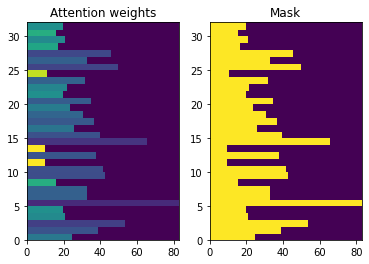

In [142]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

##Decoder architecture

In [143]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

    
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [144]:
decoder = Decoder(target_text_processor, UNITS)

In [145]:
logits = decoder(ex_context, ex_tar_in)
print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (32, 83, 128)
input target tokens shape: (batch, t) (32, 69)
logits shape shape: (batch, target_vocabulary_size) (32, 69, 10000)


##Inference

In [146]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [147]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [148]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [149]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'\xda\xa9\xdb\x8c\xd8\xa7\xdb\x94 \xda\xa9\xd9\x85\xd8\xb1\xdb\x8c\xda\xba \xd8\xa8\xda\xbe\xdb\x8c\xd8\xac\xdb\x8c\xda\xaf\xd8\xa7 \xd8\xaa\xd8\xb1\xd9\x82\xdb\x8c \xd9\xbe\xdb\x8c\xd9\xbe \xd8\xb4\xd8\xa7\xd9\x84\xdb\x8c\xd9\x85 \xd8\xa8\xd9\x88\xd9\x84\xd8\xa7 \xd9\x86\xd9\x88\xd8\xb1 \xd9\x85\xd9\x88\xd9\x82\xd8\xb9\xdb\x81 \xda\xa9\xd9\x86\xda\xaf\xd8\xa7\xd9\x84\xd9\x88\xda\xba',
       b'\xd8\xb3\xd9\x85\xd8\xac\xda\xbe\xd8\xa7\xdb\x8c\xd8\xa7 \xd8\xb3\xd9\x84\xd8\xb7\xd9\x86\xd8\xaa \xd9\x84\xd8\xa7\xd9\x8a\xd9\x94\xd8\xad\xdb\x81 \xd8\xaf\xd8\xa8\xd8\xa7\xdb\x8c\xd8\xa7 \xd9\x81\xd8\xb1\xd9\x85\xd8\xa7\xd9\x86\xd8\xa8\xd8\xb1\xd8\xaf\xd8\xa7\xd8\xb1 \xd8\xaa\xdb\x81\xdb\x81 \xd8\xaa\xd8\xb9\xd8\xb7\xd9\x84 \xda\x86\xd9\xb9\xd8\xa7\xd9\x86 \xd8\xa8\xda\x91\xdb\x92 \xd8\xb2\xdb\x8c\xd8\xb1\xdb\x81',
       b'\xd8\xb1\xd9\x8a\xd9\x94\xdb\x8c\xd8\xb3 \xd9\x85\xd8\xaa\xd9\x88\xd8\xb3\xd8\xb7 \xd8\xb9\xd8\xa7\xd8\xaf\xd9\x84 \xd9\x85\xd8\xa7\xd9\x86\xd9\x88 \xd9\x85\xd8\xaa\

##Model

In [150]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                context_text_processor,
                target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [151]:
# model = Translator(UNITS, context_text_processor, target_text_processor)

# logits = model((ex_context_tok, ex_tar_in))

model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (32, 83)
Target tokens, shape: (batch, t) (32, 69)
logits, shape: (batch, t, target_vocabulary_size) (32, 69, 10000)


##Training

In [152]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [153]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [154]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [155]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.2103405, 'expected_acc': 0.0001}

In [156]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 10s 48ms/step - loss: 9.2090 - masked_acc: 3.5706e-04 - masked_loss: 9.2090


{'loss': 9.208955764770508,
 'masked_acc': 0.00035706369089893997,
 'masked_loss': 9.208955764770508}

In [157]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
100/100 [==============================] - 37s 222ms/step - loss: 6.5703 - masked_acc: 0.0530 - masked_loss: 6.5703 - val_loss: 5.8668 - val_masked_acc: 0.0918 - val_masked_loss: 5.8668
Epoch 2/100
100/100 [==============================] - 15s 150ms/step - loss: 5.4586 - masked_acc: 0.1468 - masked_loss: 5.4586 - val_loss: 4.9845 - val_masked_acc: 0.1842 - val_masked_loss: 4.9845
Epoch 3/100
100/100 [==============================] - 12s 116ms/step - loss: 4.8804 - masked_acc: 0.2009 - masked_loss: 4.8804 - val_loss: 4.6183 - val_masked_acc: 0.2179 - val_masked_loss: 4.6183
Epoch 4/100
100/100 [==============================] - 11s 106ms/step - loss: 4.5355 - masked_acc: 0.2306 - masked_loss: 4.5352 - val_loss: 4.4100 - val_masked_acc: 0.2329 - val_masked_loss: 4.4100
Epoch 5/100
100/100 [==============================] - 11s 105ms/step - loss: 4.2487 - masked_acc: 0.2556 - masked_loss: 4.2487 - val_loss: 4.2041 - val_masked_acc: 0.2544 - val_masked_loss: 4.2041
Epoch 6/10

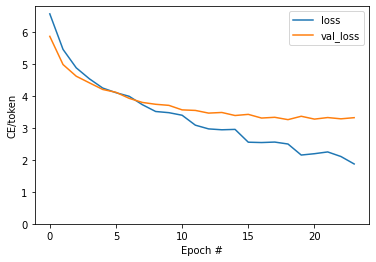

In [158]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

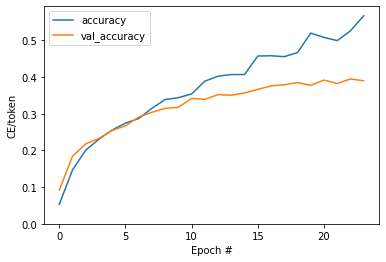

In [159]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/NLP_Project/attention_model')

In [160]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)
        
        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

##Testing

In [49]:
def test_data():
  test_source = []
  test_target = []
  with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/test.ur', "r", encoding="utf-8") as f:
      lines_urdu = f.read().split("\n")
  with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bible/test.en', "r", encoding="utf-8") as f:
      lines_eng = f.read().split("\n")
  for each in lines_eng:
    test_source.append(each)
  for each in lines_urdu:
    test_target.append(each)
  return test_source,test_target

In [50]:
test_source,test_target=test_data()

In [51]:
print(test_source[45])
print(test_target[45])
print(len(test_source))

And the nations were angry , and thy wrath is come , and the time of the dead , that they should be judged , and that thou shouldest give reward unto thy servants the prophets , and to the saints , and them that fear thy name , small and great ; and shouldest destroy them which destroy the earth .
اور قوموں کو غصہ آیا اور تیرا غضب نازل ہؤا اور وہ وقت آ پہنچا ہے کہ مردوں کا انصاف کیا جائے اور تیرے بندوں نبیوں اور مقدسوں اور ان چھوٹے بڑوں کو جو تیرے نام سے ڈرتے ہیں اجر دیا جائے اور زمین کے تباہ کرنے والوں کو تباہ کیا جائے ۔
258


In [52]:
result = [] 
total = 0
for i in range(len(test_source)):
    result.append(model.translate([test_source[i]])[0].numpy().decode())
    total += nltk.translate.bleu_score.sentence_bleu([test_target[i]], result[-1], weights=[1])
print(total/len(test_source))

0.6995529724014304


##BLEU Score

In [53]:
bleu_score=total/len(test_source)
print("Bleu Score: ",bleu_score)

Bleu Score:  0.6995529724014304


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/NLP_Project/Bleu_Score_With_Attention', 'wb') as file:
  pickle.dump(bleu_score, file)

In [55]:
print(test_source[200])
print(test_target[200])


And when the thousand years are expired , Satan shall be loosed out of his prison .
اور جب ہزار برس پورے ہو چکیں گے تو شیطان قید سے چھوڑ دیا جائے گا ۔


In [164]:
result = model.translate(["and whosoever liveth and believeth in me shall never die . believest thou this ?"]) # Are you still home
result[0].numpy().decode()

'اور جو کوئی مجھ پر ایمان لائے اور مجھ پر ایمان لاتا ہے وہ ابد تک کبھی کبھی نہ مریگا ۔ کیا تو یہ ہے ؟ ۔ '